In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import combinations

In [4]:
def generate_subsets(n):
    # Generate all possible subsets of size 1 to n.
    for size in range(1, n + 1):
        for subset in combinations(range(n), size):
            yield subset
            # print(subset)


def check_p(matrix):
    n = len(matrix)

    # Compute the determinant of the whole matrix first.
    determinant = np.linalg.det(matrix)
    if determinant <= 0:
        return False  # Return immediately if the whole matrix has a non-positive determinant

    # Check the determinants of diagonal elements (smallest subset) next.
    for i in range(n):
        submatrix = matrix[i, i]
        if submatrix <= 0:
            return False  # Return immediately if any diagonal element is non-positive

    # Initialize the generator to get subsets.
    subset_generator = generate_subsets(n)

    # Check the determinants of other subsets.
    for subset in subset_generator:
        if len(subset) > 1:
            submatrix = matrix[np.ix_(subset, subset)]
            determinant = np.linalg.det(submatrix)
            if determinant <= 0:
                return False  # Return immediately if a non-positive determinant is found

    return True # Return True if all determinants are positive


def generate_matrix(n):
    # Generate a random matrix with values between -1 and 1
    matrix = np.random.uniform(-1, 1, (n, n))
    # Set diagonal elements to 1
    np.fill_diagonal(matrix, 1)
    
    return matrix

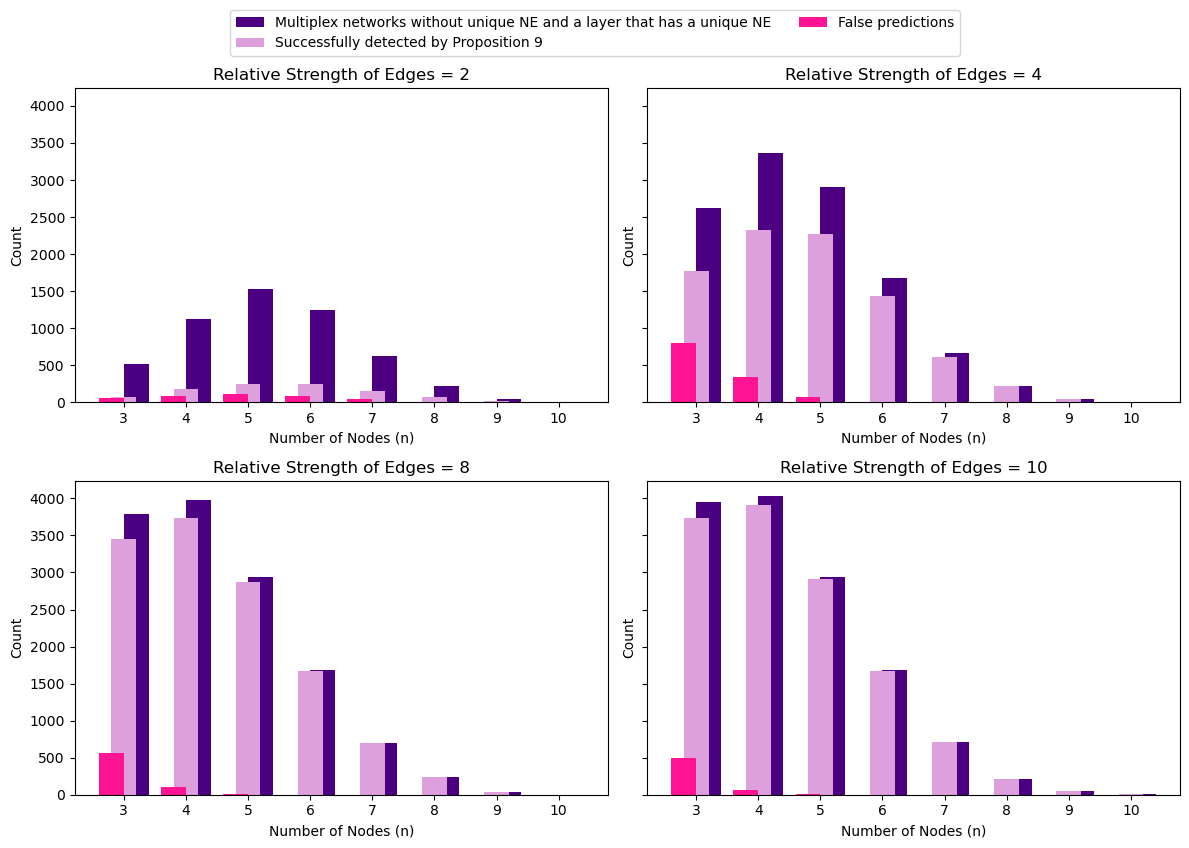

In [5]:
import numpy as np
import matplotlib.pyplot as plt
n_list = [3, 4, 5, 6, 7, 8, 9, 10]
kappa = 0.5
iterations = 5000
strength_list = [2, 4, 8, 10]

# Prepare the figure for 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
axs = axs.flatten()  # Flatten the axs array for easy indexing

# Bar colors
bar_color1 = 'plum'
bar_color2 = 'indigo'

# Lists to store success and false prediction rates for each strength
percent_success_by_strength = [[] for _ in strength_list]
percent_false_by_strength = [[] for _ in strength_list]


# Loop through each strength value
for idx, strength in enumerate(strength_list):
    condition_true_counts = []
    total_counts = []
    total_all = []
    false_positive_list = []

    for n in n_list:
        condition_true_count = 0
        total_count = 0
        total_count_all = 0
        false_positive = 0

        for i in range(iterations):
            G1 = generate_matrix(n)
            G2 = generate_matrix(n)*strength
            # threshold = strength * 0.2
            # G2[abs(G2) < threshold] = 0
            np.fill_diagonal(G2, 1)
            
            G = kappa * G1 + (1 - kappa) * G2
            result1 = check_p(G1)
            result2 = check_p(G2)
            result = check_p(G)

            lambda_min_G2 = np.min(np.linalg.eigvals(G2 - np.eye(n)))
            lambda_max_G1 = np.max(np.linalg.eigvals(G1 - np.eye(n)))
            condition = abs(lambda_min_G2) >= (1 / (1 - kappa)) * (1 + (kappa * lambda_max_G1))
                    
            # Check the conditions for unique NEs
            if (result1 & (not result2)) or ((not result1) & result2):
                if not result:
                    total_count += 1
                    # Check condition for the matrices here
                    if condition:
                        condition_true_count += 1
            # counting false predictions
            if result:
                # total_count_all += 1
                if condition:
                    false_positive += 1

                    
        condition_true_counts.append(condition_true_count)
        total_counts.append(total_count)
        # total_all.append(total_count_all)
        false_positive_list.append(false_positive)
    
    # Calculate percentages for each 'n'
    for total_count, condition_true_count, false_positive in zip(total_counts, condition_true_counts, false_positive_list):
        success_rate = (condition_true_count / total_count * 100) if total_count else 0
        false_rate = (false_positive / total_count * 100) if total_count else 0
        percent_success_by_strength[idx].append(success_rate)
        percent_false_by_strength[idx].append(false_rate)

    # Plotting for this strength value
    ax = axs[idx]
    width = 0.4
    x = np.arange(len(n_list))

    ax.bar(x + width/2, total_counts, width, color=bar_color2)
    ax.bar(x, condition_true_counts, width, color=bar_color1)
    ax.bar(x - width/2, false_positive_list, width, color='deeppink')

    ax.set_xlabel('Number of Nodes (n)')
    ax.set_ylabel('Count')
    ax.set_title(f'Relative Strength of Edges = {strength}')
    ax.set_xticks(x)
    ax.set_xticklabels(n_list)
    # ax.legend()


labels = ['Multiplex networks without unique NE and a layer that has a unique NE', 'Successfully detected by Proposition 9', 'False predictions']
fig.legend(labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=2)
plt.tight_layout(rect=[0, 0.1, 1, 0.9])
plt.savefig('multiplex-prop-neg.png', dpi=600)
plt.show()


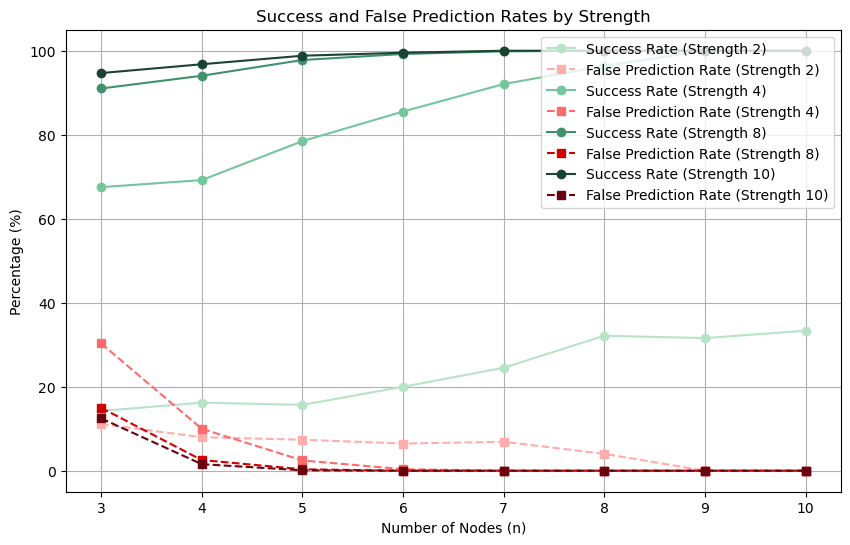

In [6]:
# Define shades of green and red for different strength values
green_shades = ['#b7e4c7', '#74c69d', '#40916c', '#1b4332']  # Light to dark green
red_shades = ['#ffadad', '#ff6b6b', '#d00000', '#6a040f']  # Light to dark red

# Plotting the line plot in a new figure
plt.figure(figsize=(10, 6))

for idx, strength in enumerate(strength_list):
    plt.plot(n_list, percent_success_by_strength[idx], marker='o', color=green_shades[idx], label=f'Success Rate (Strength {strength})')
    plt.plot(n_list, percent_false_by_strength[idx], marker='s', linestyle='--', color=red_shades[idx], label=f'False Prediction Rate (Strength {strength})')

plt.xlabel('Number of Nodes (n)')
plt.ylabel('Percentage (%)')
plt.title('Success and False Prediction Rates by Strength')
plt.legend(loc='upper right')
plt.grid(True)
# plt.savefig('multiplex-prop-neg-line.png', dpi=600)
plt.show()

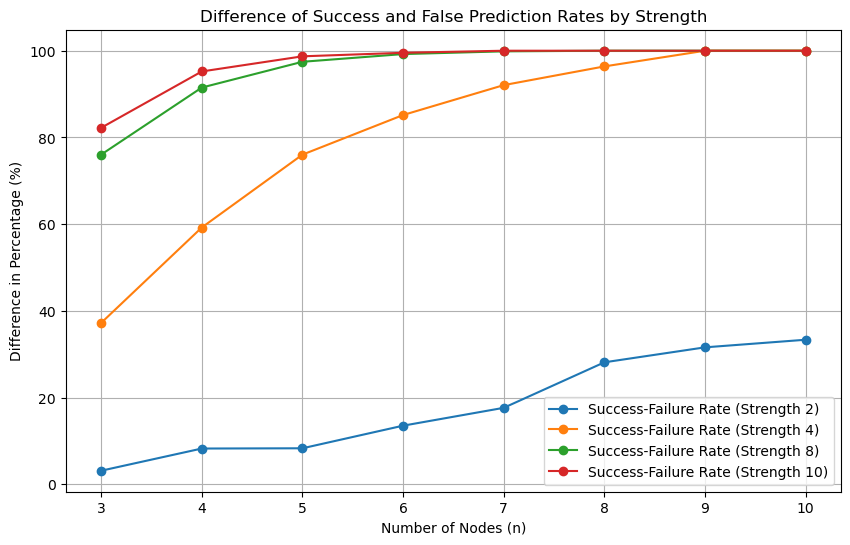

In [14]:
# Plotting the line plot in a new figure
plt.figure(figsize=(10, 6))

for idx, strength in enumerate(strength_list):
    difference_succ_fail = np.array(percent_success_by_strength[idx])-np.array(percent_false_by_strength[idx])
    plt.plot(n_list, difference_succ_fail, marker='o', label=f'Success-Failure Rate (Strength {strength})')

plt.xlabel('Number of Nodes (n)')
plt.ylabel('Difference in Percentage (%)')
plt.title('Difference of Success and False Prediction Rates by Strength')
plt.legend(loc='best')
plt.grid(True)
# plt.savefig('multiplex-prop-neg-line.png', dpi=600)
plt.show()

In [4]:
def generate_negative_matrix(n):
    # Generate a random matrix with values between -1 and 0
    matrix = np.random.uniform(-1, 0, (n, n))
    # Set diagonal elements to 1
    np.fill_diagonal(matrix, 1)
    
    return matrix

def is_m_matrix(matrix):
    B = matrix - np.eye(n)
    rho = np.max(np.abs(np.linalg.eigvals(-B)))
    return rho < 1

def is_PD_matrix(matrix):
    return np.all(np.linalg.eigvals(matrix) > 0)

def generate_symmetric(n):
    # Generate a random matrix with values between -1 and 1
    A = np.random.uniform(-1, 1, (n, n))
    matrix = (A + A.T) / 2
    # Set diagonal elements to 1
    np.fill_diagonal(matrix, 1)
    
    return matrix

def calculate_2_norm(matrix):
    # Perform Singular Value Decomposition
    U, s, V = np.linalg.svd(matrix)
    
    # The 2-norm is the largest singular value
    return max(s)

In [7]:
iterations = 10000
n_list = [3, 4, 5, 6, 7, 8, 9, 10]
kappa = 0.5

# For M-matrix
for n in n_list:
    for i in range(iterations):
        G1 = generate_negative_matrix(n)
        G2 = generate_symmetric(n)
        G = kappa * G1 + (1 - kappa) * G2
        result1 = check_p(G1)
        result2 = check_p(G2)
        result = check_p(G)
        
        lambda_max_G2 = np.max(np.linalg.eigvals(G2-np.eye(n)))
        lambda_min_G1 = np.min(np.linalg.eigvals(G1-np.eye(n)))

        if result1: # G1 is a P-matrix
            if is_m_matrix(G1): # G1 is an M-matrix
                condition = lambda_max_G2 < ((2 * kappa - 1) / (1 - kappa)) + (kappa/ (1-kappa)) * lambda_min_G1
                if condition & (not result): # condition is satisfied but G is not a P-matrix (should not happen!)
                    print("\nwelp!")

In [8]:
iterations = 10000
n_list = [3, 4, 5, 6, 7, 8, 9, 10]
kappa = 0.5

# For PD matrix
for n in n_list:
    for i in range(iterations):
        G1 = generate_symmetric(n)
        G2 = generate_symmetric(n)
        G = kappa * G1 + (1 - kappa) * G2

        result1 = is_PD_matrix(G1) # first layer has a unique NE
        result2 = is_PD_matrix(G2) # second layer has a unique NE
        result = is_PD_matrix(G) # multiplex has a unique NE

        lambda_min_G1 = np.min(np.linalg.eigvals(G1-np.eye(n)))
        lambda_max_G2 = np.max(np.linalg.eigvals(G2-np.eye(n)))

        condition = lambda_max_G2 < ((2 * kappa - 1) / (1 - kappa)) + (kappa/ (1-kappa)) * lambda_min_G1

        if result1 & condition & (not result): # first layer has a unique NE and condition is satisfied but multiplex does not have a unique NE (should not happen!)
            print("welp! n: ", n)
            break
            # print(G1)
            # print("\n")
            # print(G2)
            # print("\n")
            # print(G)
            # print("lambda_max_G1: ", lambda_max_G1)
            # print("lambda_max_G2: ", lambda_max_G2)
            # print("condition: ", condition)

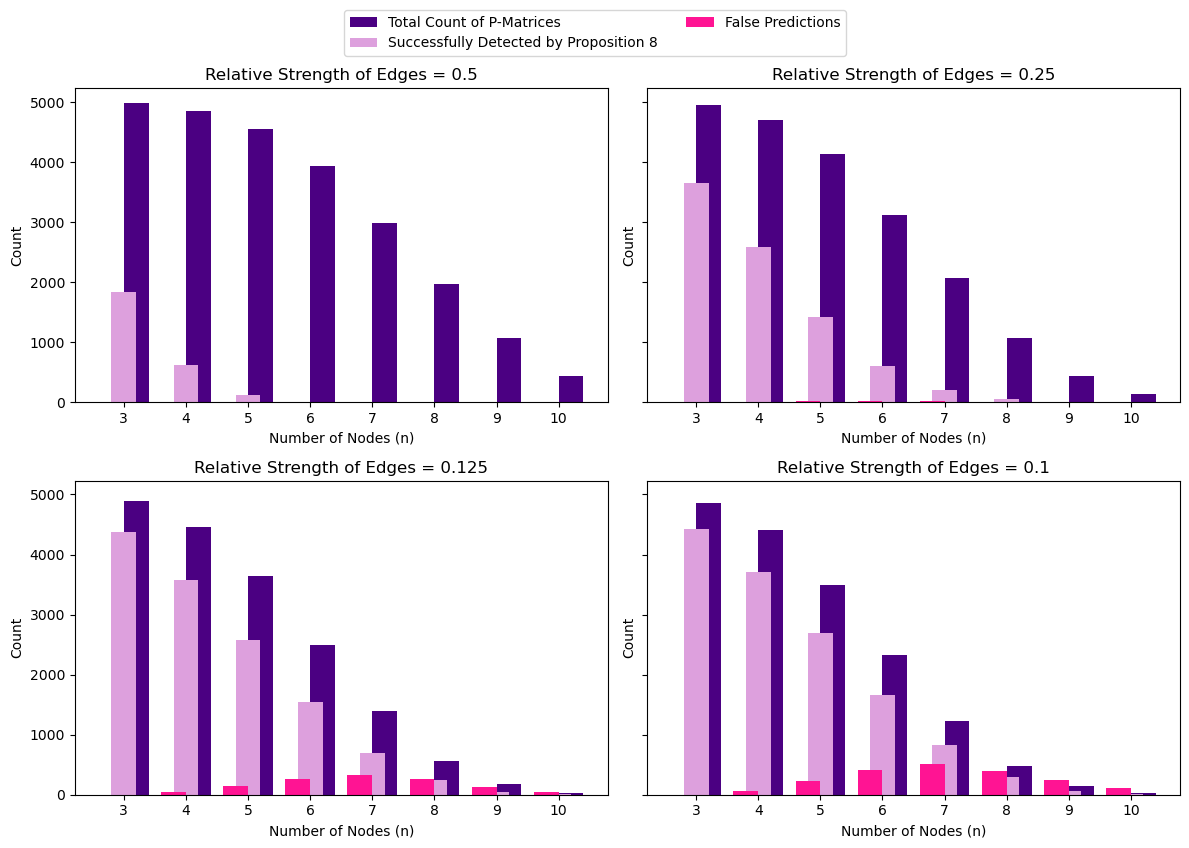

In [5]:
iterations = 5000
n_list = [3, 4, 5, 6, 7, 8, 9, 10]
kappa = 0.5
condition_help_list = []
p_matrix_total_list = []
strength_list = [0.5, 0.25, 0.125, 0.1]

# Prepare the figure for 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
axs = axs.flatten()  # Flatten the axs array for easy indexing

# Bar colors
bar_color1 = 'plum'
bar_color2 = 'indigo'

for idx, strength in enumerate(strength_list):
    condition_help_list = []
    p_matrix_total_list = []
    false_negative_list = []

    for n in n_list:
        condition_help_count = 0
        p_matrix_total_count = 0
        false_negative = 0

        for i in range(iterations):
            G1 = generate_matrix(n)
            G2 = generate_matrix(n) * strength
            G = kappa * G1 + (1 - kappa) * G2
            result = check_p(G)

            lambda_min_G1 = np.min(np.linalg.eigvals(G1-np.eye(n)))
            lambda_max_G2 = np.max(np.linalg.eigvals(G2-np.eye(n)))

            condition = lambda_max_G2 < ((2 * kappa - 1) / (1 - kappa)) + (kappa/ (1-kappa)) * lambda_min_G1

            if condition & result:
                condition_help_count += 1
            if result:
                p_matrix_total_count += 1
            if condition & (not result):
                false_negative += 1
        
        condition_help_list.append(condition_help_count)
        p_matrix_total_list.append(p_matrix_total_count)
        false_negative_list.append(false_negative)

    # Plotting for this strength value
    ax = axs[idx]
    width = 0.4
    x = np.arange(len(n_list))

    ax.bar(x + width/2, p_matrix_total_list, width, color=bar_color2)
    ax.bar(x, condition_help_list, width, color=bar_color1)
    ax.bar(x - width/2, false_negative_list, width, color='deeppink')

    ax.set_xlabel('Number of Nodes (n)')
    ax.set_ylabel('Count')
    ax.set_title(f'Relative Strength of Edges = {strength}')
    ax.set_xticks(x)
    ax.set_xticklabels(n_list)

    # for i, v in enumerate(percentages):
    #     ax.text(i, v + 5, f'{v:.1f}%', ha='center')

# Adding a single legend at the upper center
labels = ['Total Count of P-Matrices', 'Successfully Detected by Proposition 8', 'False Predictions']
fig.legend(labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=2)

plt.tight_layout(rect=[0, 0.1, 1, 0.9])
# Uncomment to save the figure
plt.savefig('multiplex-prop-pos.png', dpi=600)
plt.show()

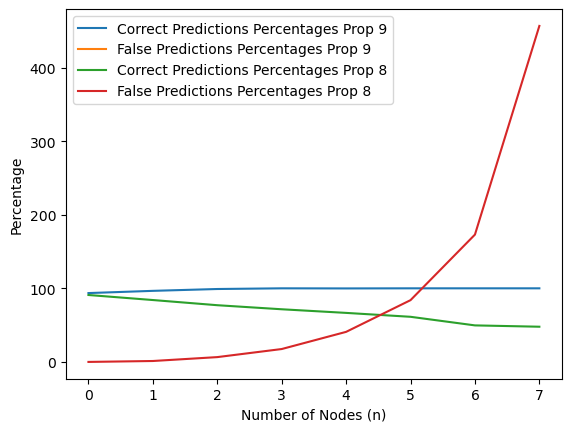

In [6]:
# Creating a figure and axis
fig, ax = plt.subplots()

# Plotting data
ax.plot(percentages_prop9, label='Correct Predictions Percentages Prop 9')
ax.plot(false_positive_percentages_prop9, label='False Predictions Percentages Prop 9')
ax.plot(percentages_prop8, label='Correct Predictions Percentages Prop 8')
ax.plot(false_positive_percentages_prop8, label='False Predictions Percentages Prop 8')

# Adding titles and labels
# ax.set_title('Comparison of Percentages')
ax.set_xlabel('Number of Nodes (n)')
ax.set_ylabel('Percentage')

# Adding a legend
ax.legend()

# Displaying the plot
plt.show()


# Max eigval experiments


In [34]:
#  define a function to compute the maximum eigenvalue of a matrix
def max_eigenvalue(matrix):
    return np.max(np.linalg.eigvals(matrix))

# define a function to generate sparse matrices of size n
def generate_sparse_matrix(n, lower, upper, threshold):
    # generate a random matrix with values between lower and upper
    matrix = np.random.uniform(lower, upper, (n, n))
    # set diagonal elements to 0
    np.fill_diagonal(matrix, 0)
    # set all elements below threshold to 0
    matrix[abs(matrix) < threshold] = 0

    return matrix

# define a function to generate random matrices of size n
def generate_random_matrix(n):
    # generate a random matrix with values between -1 and 1
    matrix = np.random.uniform(-1, 1, (n, n))
    # set diagonal elements to 0
    np.fill_diagonal(matrix, 0)

    return matrix

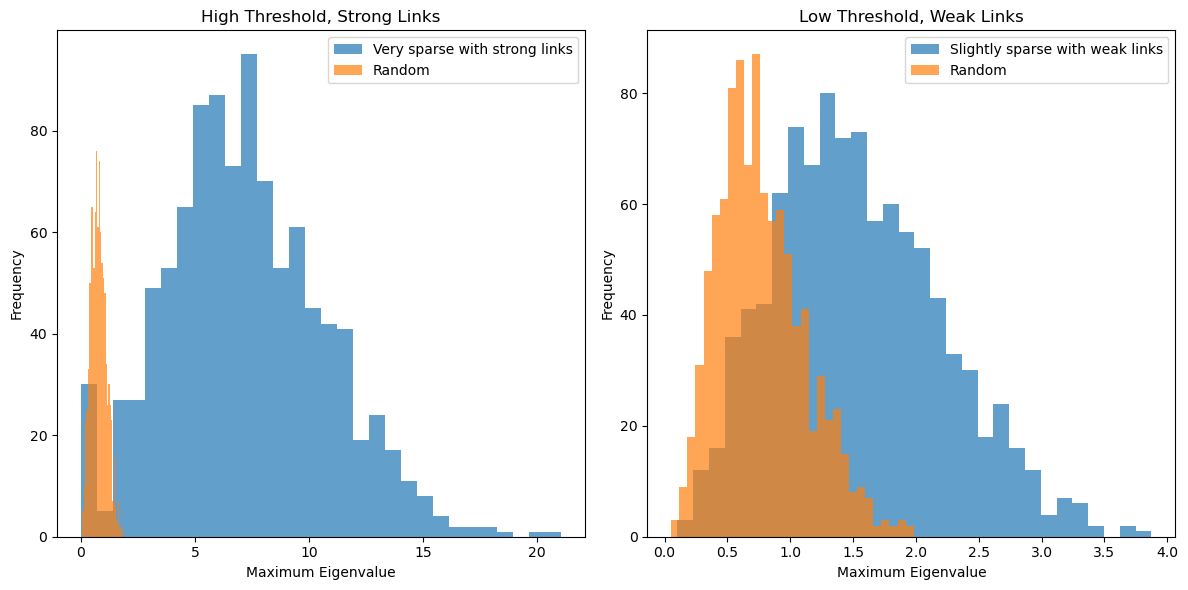

In [37]:
# Define matrix size
n = 5
num_instances = 1000

# Initialize lists to store maximum eigenvalues
max_eigenvalues_sparse_strong = []
max_eigenvalues_random_strong = []
max_eigenvalues_sparse_weak = []
max_eigenvalues_random_weak = []

for _ in range(num_instances):
    # High threshold (very sparse matrix) and strong links (high values of lower and upper)
    sparse_matrix_strong = generate_sparse_matrix(n, -10, 10, 4)
    random_matrix_strong = generate_random_matrix(n)

    # Low threshold (not very sparse) and not very strong links
    sparse_matrix_weak = generate_sparse_matrix(n, -2, 2, 0.1)
    random_matrix_weak = generate_random_matrix(n)

    # Computing max eigenvalues
    max_eigenvalues_sparse_strong.append(max_eigenvalue(sparse_matrix_strong).real)
    max_eigenvalues_random_strong.append(max_eigenvalue(random_matrix_strong).real)
    max_eigenvalues_sparse_weak.append(max_eigenvalue(sparse_matrix_weak).real)
    max_eigenvalues_random_weak.append(max_eigenvalue(random_matrix_weak).real)

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(max_eigenvalues_sparse_strong, bins=30, alpha=0.7, label='Very sparse with strong links')
plt.hist(max_eigenvalues_random_strong, bins=30, alpha=0.7, label='Random')
plt.title('High Threshold, Strong Links')
plt.xlabel('Maximum Eigenvalue')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(max_eigenvalues_sparse_weak, bins=30, alpha=0.7, label='Slightly sparse with weak links')
plt.hist(max_eigenvalues_random_weak, bins=30, alpha=0.7, label='Random')
plt.title('Low Threshold, Weak Links')
plt.xlabel('Maximum Eigenvalue')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Other experiments

/var/folders/hs/y116vr4j4yg5fcthw_l99c5r0000gn/T/ipykernel_4548/3928030750.py:37: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(G).todense()


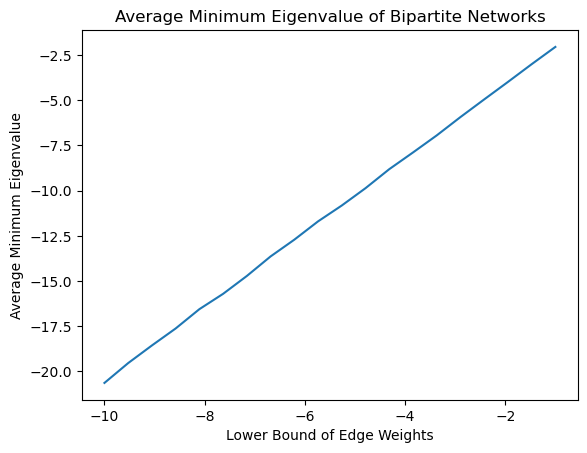

In [45]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def create_bipartite_network(n1, n2, lower, upper):
    # Create an empty bipartite graph
    G = nx.Graph()

    # Add nodes to the graph
    G.add_nodes_from(range(n1), bipartite=0)
    G.add_nodes_from(range(n1, n1 + n2), bipartite=1)

    # Generate edge weights from a uniform distribution between lower and upper
    weights = np.random.uniform(lower, upper, (n1, n2))

    # Add edges to the graph with the generated weights
    for i in range(n1):
        for j in range(n2):
            G.add_edge(i, n1 + j, weight=weights[i, j])

    return G

def min_eigenvalue(matrix):
    eigenvalues = np.linalg.eigvals(matrix)
    return np.min(eigenvalues)

def average_min_eigenvalue_experiment(n1, n2, iterations, lower_range, upper_range):
    avg_min_eigenvalues = []

    # Iterate over the range of lower and upper bounds
    for lower, upper in zip(lower_range, upper_range):
        min_eigvals = []

        # Create instances of bipartite networks and compute their min eigenvalue
        for _ in range(iterations):
            G = create_bipartite_network(n1, n2, lower, upper)
            adj_matrix = nx.adjacency_matrix(G).todense()
            min_eigval = min_eigenvalue(adj_matrix)
            min_eigvals.append(min_eigval)

        # Calculate and store the average minimum eigenvalue
        avg_min_eigenvalues.append(np.mean(min_eigvals))

    return avg_min_eigenvalues

# Parameters
n1, n2 = 5, 5  # number of nodes in each part of the bipartite network
iterations = 1000
lower_range = np.linspace(-1, -10, 20)  # Lower bounds from -1 to -10
upper_range = np.linspace(1, 10, 20)    # Upper bounds from 1 to 10

# Run the experiment
avg_min_eigvals = average_min_eigenvalue_experiment(n1, n2, iterations, lower_range, upper_range)

# Plotting
plt.plot(lower_range, avg_min_eigvals)
plt.xlabel('Lower Bound of Edge Weights')
plt.ylabel('Average Minimum Eigenvalue')
plt.title('Average Minimum Eigenvalue of Bipartite Networks')
plt.show()
